[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/dl/blob/master/mlp/mlp.ipynb)

# The Multilayer Perceptron

## Regression

Example of linear regression.

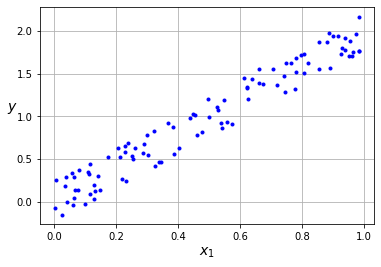

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.rand(100)
X = x.reshape(-1, 1)
y = 2*x + (np.random.rand(100)-0.5)*0.5

plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

In [2]:
def mse(output, target):
    return 0.5*(output - target)**2
  
def grad_mse(output, target):  
    return (output - target)

class MLP():
  def __init__(self, D_in, H, D_out):
    self.w1, self.b1 = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(D_in+H)),
                                  size=(D_in, H)), np.zeros(H)
    self.w2, self.b2 = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(H+D_out)),
                                  size=(H, D_out)), np.zeros(D_out)

    self.ws = []
    
    self.loss = mse
    self.grad_loss = grad_mse

  def __call__(self, x):
    self.h = np.dot(x, self.w1) + self.b1
    y_hat = np.dot(self.h, self.w2)  + self.b2
    return self.final_activation(y_hat)

  def final_activation(self, x):
    return x
    
  def fit(self, X, Y, epochs = 100, lr = 0.001):
    for e in range(epochs):    
      l = []
      for x, y in zip(X, Y): 
        # add batch dimension
        x = x[None,:]        
        y_pred = self(x) 
        # loss function
        loss = self.loss(y_pred, y).mean()
        l.append(loss)        
        # Backprop 
        # dl/dy
        dldy = self.grad_loss(y_pred, y)        
        # dl/dw2 = dl/dy * dy/dw2
        grad_w2 = np.dot(self.h.T, dldy)
        grad_b2 = dldy
        # dl/dh = dl/dy * dy/dh
        dldh = np.dot(dldy, self.w2.T)      
        # dl/dw1 = dl/dy * dy/dh * dh/dw1
        grad_w1 = np.dot(x.T, dldh)
        grad_b1 = dldh
        # Update (GD)
        self.w1 = self.w1 - lr * grad_w1
        self.b1 = self.b1 - lr * grad_b1
        self.w2 = self.w2 - lr * grad_w2
        self.b2 = self.b2 - lr * grad_b2
      self.ws.append((
          self.w1.copy(),
          self.b1.copy(),
          self.w2.copy(),
          self.b2.copy(),
      ))
      if not e % 10 and not e == 0:
        print(f'Epoch: {e}, Loss: {np.mean(l):.8f}')
    print(f'Epoch: {e+1}, Loss: {np.mean(l):.8f}')

  def predict(self, ws, x):
    w1, b1, w2, b2 = ws
    h = np.dot(x, w1) + b1
    y_hat = np.dot(h, w2) + b2
    return self.final_prediction_activation(y_hat)

  def final_prediction_activation(self, x):
    return self.final_activation(x)

In [3]:
mlp = MLP(1, 3, 1)
epochs, lr = 50, 0.01
mlp.fit(X, y, epochs, lr)

Epoch: 10, Loss: 0.01205466
Epoch: 20, Loss: 0.01158380
Epoch: 30, Loss: 0.01158051
Epoch: 40, Loss: 0.01158021
Epoch: 50, Loss: 0.01158002


In [4]:
from matplotlib import animation, rc
rc('animation', html='html5')

def plot(epoch, w):
    ax.clear()
    ax.plot(x, y, "b.")
    tit = ax.set_title(f"Epoch {epoch+1}", fontsize=14)
    X_new = np.linspace(x.min(),x.max(),100).reshape(-1, 1)    
    y_pred = mlp.predict(w, X_new)
    y_pred = y_pred.reshape(X_new.shape)
    ax.plot(X_new, y_pred, "-k")
    ax.set_xlabel("$x_1$", fontsize=14)
    ax.set_ylabel("y", rotation=0, fontsize=14)
    ax.axis([x.min(),x.max(),y.min(),y.max()])
    ax.grid(True)
    return [tit]

def get_anim(fig, ax, mlp):
    def anim(i):
        return plot(i, mlp.ws[i])
    return anim

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
animate = get_anim(fig, ax, mlp)
anim = animation.FuncAnimation(fig, animate, frames=epochs, interval=100, blit=True)
plt.close()
anim

Can we fit non-linear data ?

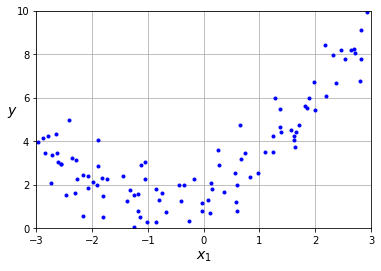

In [5]:
np.random.seed(42)
m = 100
x = 6 * np.random.rand(m, 1) - 3
y = 0.5 * x**2 + x + 2 + np.random.randn(m, 1)

plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.grid(True)
plt.show()

In [6]:
mlp = MLP(1, 3, 1)
epochs, lr = 50, 0.001
mlp.fit(x, y, epochs, lr)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
animate = get_anim(fig, ax, mlp)
anim = animation.FuncAnimation(fig, animate, frames=epochs, interval=100, blit=True)
plt.close()
anim

Epoch: 10, Loss: 1.56148740
Epoch: 20, Loss: 1.56101363
Epoch: 30, Loss: 1.56055506
Epoch: 40, Loss: 1.56010402
Epoch: 50, Loss: 1.55970440


A linear combination of linear functions is a linear function. We need non-linearity !

In [7]:
def relu(x):
  return np.maximum(0, x)

def reluPrime(x):
  return x > 0

class MLPrelu(MLP):
  def __call__(self, x):
    self.h_pre = np.dot(x, self.w1) + self.b1
    self.h = relu(self.h_pre)
    y_hat = np.dot(self.h, self.w2) + self.b2 
    return self.final_activation(y_hat)
    
  def fit(self, X, Y, epochs = 100, lr = 0.001):
    for e in range(epochs):    
      l = []
      for x, y in zip(X, Y):            
        x = x[None,:]        
        y_pred = self(x) 
        loss = self.loss(y_pred, y).mean()
        l.append(loss)        
        # Backprop 
        dldy = self.grad_loss(y_pred, y)        
        grad_w2 = np.dot(self.h.T, dldy)
        grad_b2 = dldy
        dldh = np.dot(dldy, self.w2.T)*reluPrime(self.h_pre)      
        grad_w1 = np.dot(x.T, dldh)
        grad_b1 = dldh
        # Update (GD)
        self.w1 = self.w1 - lr * grad_w1
        self.b1 = self.b1 - lr * grad_b1
        self.w2 = self.w2 - lr * grad_w2
        self.b2 = self.b2 - lr * grad_b2
      self.ws.append((
          self.w1.copy(),
          self.b1.copy(),
          self.w2.copy(),
          self.b2.copy(),
      ))
      if not e % 10 and not e == 0:
        print(f'Epoch: {e}, Loss: {np.mean(l):.8f}')
    print(f'Epoch: {e+1}, Loss: {np.mean(l):.8f}')

  def predict(self, ws, x):
    w1, b1, w2, b2 = ws
    h = relu(np.dot(x, w1) + b1)
    y_hat = np.dot(h, w2) + b2
    return self.final_prediction_activation(y_hat)

In [8]:
mlp = MLPrelu(1, 3, 1)
epochs, lr = 50, 0.01
mlp.fit(x, y, epochs, lr)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
animate = get_anim(fig, ax, mlp)
anim = animation.FuncAnimation(fig, animate, frames=epochs, interval=100, blit=True)
plt.close()
anim

Epoch: 10, Loss: 0.45875435
Epoch: 20, Loss: 0.45841872
Epoch: 30, Loss: 0.45827976
Epoch: 40, Loss: 0.45816556
Epoch: 50, Loss: 0.45807852


## Binary Classification

We are going to use the Iris dataset for Scikit-learn. We use only two features to be able to do the visualizations.

In [9]:
import numpy as np
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_norm = (X - X_mean) / X_std

y = iris.target 

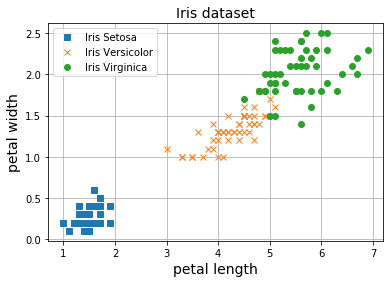

In [10]:
plt.plot(X[y==0, 0], X[y==0, 1], 's', label="Iris Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], 'x', label="Iris Versicolor")
plt.plot(X[y==2, 0], X[y==2, 1], 'o', label="Iris Virginica")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

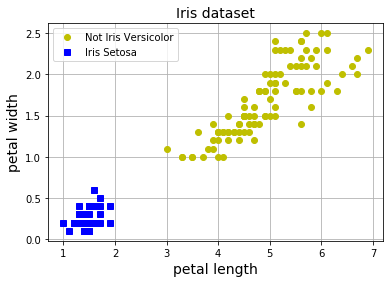

In [11]:
# keep data for binary classification

y = (iris.target == 0).astype(np.int)

plt.plot(X[y==0, 0], X[y==0, 1], 'yo', label="Not Iris Versicolor")
plt.plot(X[y==1, 0], X[y==1, 1], 'bs', label="Iris Setosa")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

In [12]:
class MLPreluBinaryClass(MLPrelu):    
  def final_activation(self, x):
    return x > 0

In [13]:
mlp = MLPreluBinaryClass(2, 3, 1)
epochs, lr = 50, 0.001
mlp.fit(X_norm, y, epochs, lr)

Epoch: 10, Loss: 0.01666667
Epoch: 20, Loss: 0.01000000
Epoch: 30, Loss: 0.00666667
Epoch: 40, Loss: 0.00333333
Epoch: 50, Loss: 0.00666667


In [14]:
from matplotlib import animation, rc
rc('animation', html='html5')

def plot(epoch, w, X, y, axes, label):
    ax.clear()
    tit = ax.set_title(f"Epoch {epoch+1}", fontsize=14)
    x0, x1 = np.meshgrid(
            np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
            np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
        )
    
    X_new = (np.c_[x0.ravel(), x1.ravel()] - X_mean)/X_std
    y_predict = mlp.predict(w, X_new)
    zz = y_predict.reshape(x0.shape)

    ax.plot(X[y==0, 0], X[y==0, 1], "bs", label=f"Not {label}")
    ax.plot(X[y==1, 0], X[y==1, 1], "yo", label=f"{label}")

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

    ax.contourf(x0, x1, zz, cmap=custom_cmap)
    ax.set_xlabel("Petal length", fontsize=14)
    ax.set_ylabel("Petal width", fontsize=14)
    ax.legend(loc="lower right", fontsize=14)
    ax.axis(axes)
    return [tit]

def get_anim(fig, ax, mlp, X, y, axes = [0, 5, 0, 2], label="Iris-Setosa"):
    def anim(i):
        return plot(i, mlp.ws[i], X, y, axes, label)
    return anim

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
animate = get_anim(fig, ax, mlp, X, y)
anim = animation.FuncAnimation(fig, animate, frames=epochs, interval=100, blit=True)
plt.close()
anim

In [15]:
X2 = X[iris.target != 0]
X2_norm = (X2 - X_mean) / X_std

y2 = (iris.target == 1).astype(np.int)[iris.target != 0]

In [16]:
mlp = MLPreluBinaryClass(2, 3, 1)
epochs, lr = 50, 0.001
mlp.fit(X2_norm, y2, epochs, lr)

Epoch: 10, Loss: 0.05000000
Epoch: 20, Loss: 0.03500000
Epoch: 30, Loss: 0.03500000
Epoch: 40, Loss: 0.03500000
Epoch: 50, Loss: 0.03500000


In [17]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
animate = get_anim(fig, ax, mlp, X2, y2, axes = [2.5, 7.5, 0.5, 2.8], label="Iris-Versicolor")
anim = animation.FuncAnimation(fig, animate, frames=epochs, interval=100, blit=True)
plt.close()
anim

## Multi-class Classification

Here you can see how to build a two layer MLP for multi-class classification.

In [18]:
def crossentropy(output, target):
    logits = output[np.arange(len(output)),target]
    entropy = - logits + np.log(np.sum(np.exp(output),axis=-1))
    return entropy
  
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

def grad_crossentropy(output, target):
    answers = np.zeros_like(output)
    answers[np.arange(len(output)),target] = 1    
    return (- answers + softmax(output)) / output.shape[0]

class MLPreluClass(MLPrelu):
  def __init__(self, D_in, H, D_out):
    super().__init__(D_in, H, D_out)
    self.loss = crossentropy
    self.grad_loss = grad_crossentropy

  def final_prediction_activation(self, x):
    return np.argmax(softmax(x), axis=1) 

In [19]:
Y = iris.target

mlp = MLPreluClass(2, 3, 3)
epochs, lr = 100, 0.02
mlp.fit(X_norm, Y, epochs, lr)

Epoch: 10, Loss: 0.17616688
Epoch: 20, Loss: 0.09377951
Epoch: 30, Loss: 0.07956992
Epoch: 40, Loss: 0.07526364
Epoch: 50, Loss: 0.07349176
Epoch: 60, Loss: 0.07256560
Epoch: 70, Loss: 0.07199239
Epoch: 80, Loss: 0.07159138
Epoch: 90, Loss: 0.07129502
Epoch: 100, Loss: 0.07109372


In [20]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(epoch, X, y, classifier, w, resolution=0.02):
    ax.clear()
    tit = ax.set_title(f"Epoch {epoch+1}", fontsize=14)
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    X_new = (np.array([xx1.ravel(), xx2.ravel()]).T - X_mean)/X_std
    Z = classifier.predict(w, X_new)
    #print(Z)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    ax.set_xlabel('petal length', fontsize=14)
    ax.set_ylabel('petal width', fontsize=14)
    classes = ["Iris-Setosa", "Iris-Versicolor", "Iris-Virginica"]
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=classes[cl], 
                    edgecolor='black')
    ax.legend(loc='upper left', fontsize=14)
    return [tit]
        
def get_anim(fig, ax, X, y, model):
    def anim(i):
        return plot_decision_regions(i, X, y, model, model.ws[i])
    return anim

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
animate = get_anim(fig, ax, X, Y, mlp)
anim = animation.FuncAnimation(fig, animate, frames=epochs, interval=100, blit=True)
plt.close()
anim

What if we want more layers ? Or different activation functions ? We need more flexibility.

## MLP Framework

Building our own MLP framework to be able to solve the problems with the following API (inspired in Pytorch).

```
D_in, H, D_out = 2, 3, 2

mlp = MLP([
    Linear(D_in, H),
    ReLU(),
    Linear(H, D_out)
])

optimizer = SGD(mlp, lr=0.1)
loss = CrossEntropy(mlp)

epochs = 100
for e in range(epochs):
  for x, y in zip(X, Y):
    y_pred = mlp(x)    
    loss(y_pred, y)
    loss.backward()    
    optimizer.update()
```

In [21]:
class MLP:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def __call__(self, x):
        return self.forward(x)

In [22]:
class Layer():
    def __init__(self):
        self.params = []
        self.grads = []

    def __call__(self, x):
        return x

    def backward(self, grad):
        return grad

    def update(self, params):
        return


class Linear(Layer):
    def __init__(self, d_in, d_out):
        self.w = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(d_in+d_out)),
                                  size=(d_in, d_out))
        self.b = np.zeros(d_out)

    def __call__(self, x):
        self.x = x
        self.params = [self.w, self.b]
        return np.dot(x, self.w) + self.b

    def backward(self, grad_output):
        grad = np.dot(grad_output, self.w.T)
        self.grad_w = np.dot(self.x.T, grad_output)
        self.grad_b = grad_output.mean(axis=0)*self.x.shape[0]
        self.grads = [self.grad_w, self.grad_b]
        return grad

    def update(self, params):
        self.w = params[0]
        self.b = params[1]


class ReLU(Layer):
    def __call__(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        grad = self.x > 0
        return grad_output*grad

In [23]:
class SGD():
    def __init__(self, net, lr):
        self.net = net
        self.lr = lr

    def update(self):
        for layer in self.net.layers:
            layer.update([
                params - self.lr*grads
                for params, grads in zip(layer.params, layer.grads)
            ])


In [24]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1, keepdims=True)


class CrossEntropy():
    def __init__(self, net):
        self.net = net

    def __call__(self, output, target):
        self.output, self.target = output, target
        logits = output[np.arange(len(output)), target]
        loss = - logits + np.log(np.sum(np.exp(output), axis=-1))
        loss = loss.mean()
        return loss

    def grad_crossentropy(self):
        answers = np.zeros_like(self.output)
        answers[np.arange(len(self.output)), self.target] = 1
        return (- answers + softmax(self.output)) / self.output.shape[0]

    def backward(self):
        grad = self.grad_crossentropy()
        for layer in reversed(self.net.layers):
            grad = layer.backward(grad)

In [27]:
D_in, H, D_out = 2, 30, 3

mlp = MLP([
    Linear(D_in, H),
    ReLU(),
    Linear(H, D_out)
])

optimizer = SGD(mlp, lr=0.01)
loss = CrossEntropy(mlp)

epochs = 50
for e in range(1,epochs+1):
  l = []
  for x, y in zip(X_norm, Y):            
    x = x[None,:]      
    y_pred = mlp(x)    
    l.append(loss(y_pred, y))
    loss.backward()    
    optimizer.update()
  print(f'Epoch: {e}, Loss: {np.mean(l):.4f}')

Epoch: 1, Loss: 0.7222
Epoch: 2, Loss: 0.4938
Epoch: 3, Loss: 0.3920
Epoch: 4, Loss: 0.3215
Epoch: 5, Loss: 0.2724
Epoch: 6, Loss: 0.2361
Epoch: 7, Loss: 0.2086
Epoch: 8, Loss: 0.1876
Epoch: 9, Loss: 0.1710
Epoch: 10, Loss: 0.1578
Epoch: 11, Loss: 0.1471
Epoch: 12, Loss: 0.1383
Epoch: 13, Loss: 0.1310
Epoch: 14, Loss: 0.1249
Epoch: 15, Loss: 0.1197
Epoch: 16, Loss: 0.1153
Epoch: 17, Loss: 0.1115
Epoch: 18, Loss: 0.1082
Epoch: 19, Loss: 0.1054
Epoch: 20, Loss: 0.1028
Epoch: 21, Loss: 0.1006
Epoch: 22, Loss: 0.0986
Epoch: 23, Loss: 0.0968
Epoch: 24, Loss: 0.0952
Epoch: 25, Loss: 0.0938
Epoch: 26, Loss: 0.0925
Epoch: 27, Loss: 0.0913
Epoch: 28, Loss: 0.0902
Epoch: 29, Loss: 0.0893
Epoch: 30, Loss: 0.0884
Epoch: 31, Loss: 0.0875
Epoch: 32, Loss: 0.0868
Epoch: 33, Loss: 0.0861
Epoch: 34, Loss: 0.0854
Epoch: 35, Loss: 0.0848
Epoch: 36, Loss: 0.0843
Epoch: 37, Loss: 0.0837
Epoch: 38, Loss: 0.0832
Epoch: 39, Loss: 0.0828
Epoch: 40, Loss: 0.0823
Epoch: 41, Loss: 0.0819
Epoch: 42, Loss: 0.0816
E

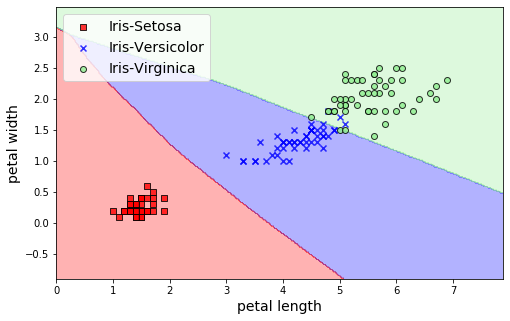

In [28]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
# plot the decision surface
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                       np.arange(x2_min, x2_max, 0.02))
X_new = (np.array([xx1.ravel(), xx2.ravel()]).T - X_mean)/X_std
Z = mlp(X_new)
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx1.shape)
colors = ('red', 'blue', 'lightgreen')
cmap = ListedColormap(colors[:len(np.unique(Y))])
ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
ax.set_xlim(xx1.min(), xx1.max())
ax.set_ylim(xx2.min(), xx2.max())
ax.set_xlabel('petal length', fontsize=14)
ax.set_ylabel('petal width', fontsize=14)
markers = ('s', 'x', 'o', '^', 'v')
classes = ["Iris-Setosa", "Iris-Versicolor", "Iris-Virginica"]
for idx, cl in enumerate(np.unique(Y)):
        ax.scatter(x=X[Y == cl, 0], 
                    y=X[Y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=classes[cl], 
                    edgecolor='black')
ax.legend(loc='upper left', fontsize=14)
plt.show()

Explore the effect of the number of layers, activation functions, etc ... here: https://playground.tensorflow.org/